This notebook depends on the `mean-field` codebase

## Imports

In [1]:
import itertools

import functools

import numpy as np
import copy
import matplotlib
import matplotlib.pyplot as plt
import xyzpy as xyz


from scipy.optimize import minimize
from scipy.optimize import LinearConstraint
import einops

import importlib
from datetime import datetime

from mean_field import func_utils
from mean_field import lattices
from mean_field import node_collections
from mean_field import plotting_utils
from mean_field import landau_energies

In [2]:
lattices = importlib.reload(lattices)
plottting_utils = importlib.reload(plotting_utils)


## Set up lattice

### Kagome bow tie

In [16]:
size_x = 8
size_y = 8
height = np.sqrt(3)/2  # height of the unit cell
unit_cell_points = np.stack([
  np.array([0.5, 0]), np.array([-0.5, 0.]), np.array([0., np.sqrt(3) / 2.])
  ]
) 
unit_cell = lattices.Lattice(unit_cell_points)
a1 = np.array([2.0, 0.0])
a2 = np.array([1.0, np.sqrt(3.0)])
kagome_lattice = lattices.Lattice(unit_cell_points).get_expanded_lattice(size_x, size_y, a1, a2)


Text(0.5, 0.98, 'Kagome lattice')

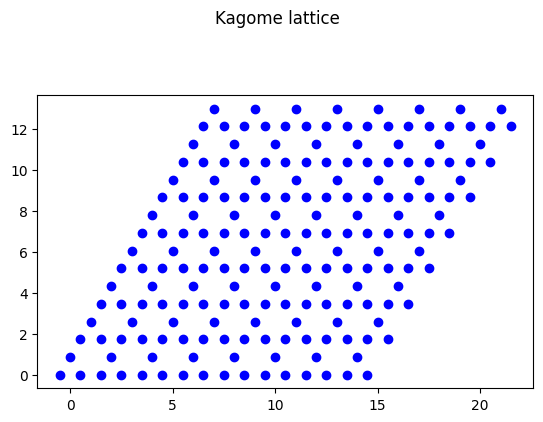

In [17]:
fig, ax = plt.subplots()
plotting_utils.plot_lattice(kagome_lattice, ax)
ax.set_aspect('equal')
fig.suptitle(r'Kagome lattice')

Text(0.5, 0.98, 'Kagome lattice restricted')

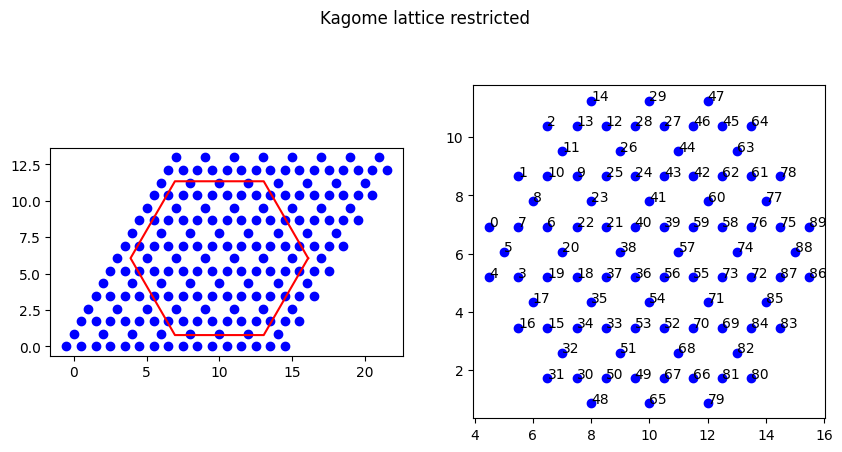

In [5]:
hexagon = lattices.generate_shapely_hexagon(6.1, 10., 7. * height)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
plotting_utils.plot_lattice(kagome_lattice, axes[0])
plotting_utils.plot_polygon(hexagon, axes[0])
axes[0].set_aspect('equal')
fig.suptitle(r'Kagome lattice restricted')

kagome_restrcited = lattices.get_restricted(kagome_lattice, hexagon)
plotting_utils.plot_lattice(kagome_restrcited, axes[1], annotate=True)
axes[1].set_aspect('equal')
fig.suptitle(r'Kagome lattice restricted')

Text(0.5, 0.98, 'Kagome lattice nearest neighbour bonds')

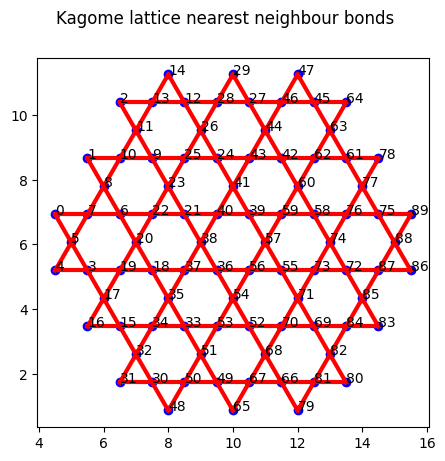

In [6]:
nodes_nn = node_collections.get_nearest_neighbors(kagome_restrcited, 1.01)
fig, ax = plt.subplots()
plotting_utils.plot_lattice(kagome_restrcited, ax, annotate=True)
plotting_utils.plot_bonds(nodes_nn, ax)
ax.set_aspect('equal')
fig.suptitle(r'Kagome lattice nearest neighbour bonds')

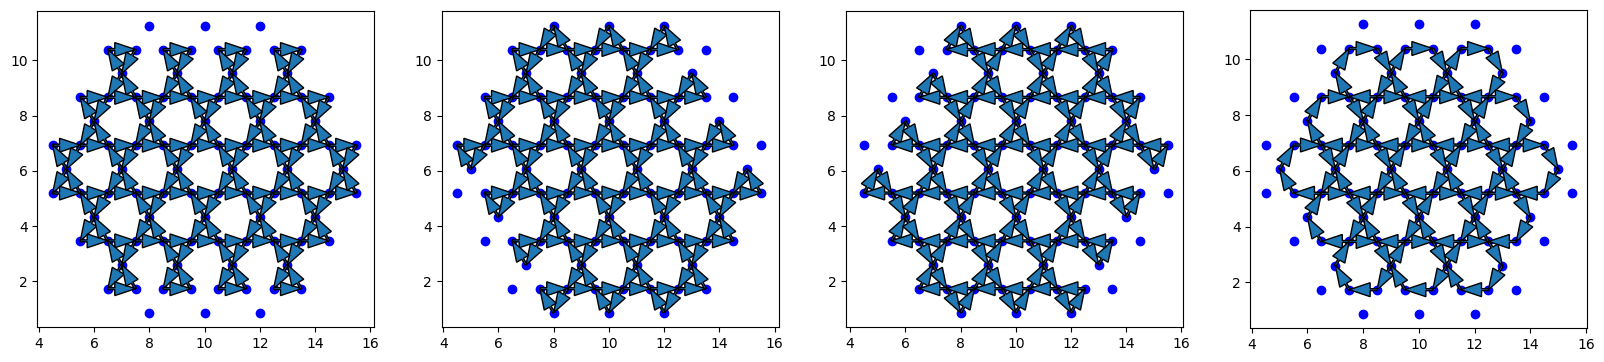

In [7]:
bow_tie_nodes_1 = np.array([
    [0, 7, 7, 5, 5, 4, 4, 3, 3, 5, 5, 0]
])
bow_tie_nodes_2 = np.array([
    [0, 7, 7, 6, 6, 8, 8, 7, 7, 5, 5, 0]
])
bow_tie_nodes_3 = np.array([
  [4, 5, 5, 3, 3, 17, 17, 19, 19, 3, 3, 4]
])
hexagon_nodes = np.array([
  [3, 5, 5, 7, 7, 6, 6, 20, 20, 19, 19, 3]
])
all_loops_nodes = [bow_tie_nodes_1, bow_tie_nodes_2, bow_tie_nodes_3, hexagon_nodes]
all_base_loops = []
for loop_nodes in all_loops_nodes:
  base_loop = node_collections.NodesCollection(loop_nodes, kagome_restrcited)
  all_base_loops.append(base_loop)
n_cols = len(all_base_loops)
fig, axarray = plt.subplots(1, n_cols, figsize=(n_cols * 5, 5))
for i, (base_loop, ax) in enumerate(zip(all_base_loops, axarray)):
  plotting_utils.plot_lattice(kagome_restrcited, ax)
  plotting_utils.plot_loops(
      node_collections.tile_on_lattice(base_loop, a1, a2, 8),
      # base_loop,
      ax, plot_with_arrows=True
  )
  ax.set_aspect('equal')

In [8]:
nodes_nn.lattice.n_sites

90

In [9]:
nodes_nn.nodes

array([[ 0,  5],
       [ 0,  7],
       [ 1,  8],
       [ 1, 10],
       [ 2, 11],
       [ 2, 13],
       [ 3,  4],
       [ 3,  5],
       [ 3, 17],
       [ 3, 19],
       [ 4,  5],
       [ 5,  7],
       [ 6,  7],
       [ 6,  8],
       [ 6, 20],
       [ 6, 22],
       [ 7,  8],
       [ 8, 10],
       [ 9, 10],
       [ 9, 11],
       [ 9, 23],
       [ 9, 25],
       [10, 11],
       [11, 13],
       [12, 13],
       [12, 14],
       [12, 26],
       [12, 28],
       [13, 14],
       [15, 16],
       [15, 17],
       [15, 32],
       [15, 34],
       [16, 17],
       [17, 19],
       [18, 19],
       [18, 20],
       [18, 35],
       [18, 37],
       [19, 20],
       [20, 22],
       [21, 22],
       [21, 23],
       [21, 38],
       [21, 40],
       [22, 23],
       [23, 25],
       [24, 25],
       [24, 26],
       [24, 41],
       [24, 43],
       [25, 26],
       [26, 28],
       [27, 28],
       [27, 29],
       [27, 44],
       [27, 46],
       [28, 29],
       [30, 31

In [10]:
nodes_nn
b_init = np.ones(nodes_nn.count)
# b_init = np.random.rand(nodes_nn.count)
b_matrix = np.zeros((nodes_nn.lattice.n_sites, nodes_nn.lattice.n_sites))
for b_l, node in zip(b_init, nodes_nn.nodes):
  # print(node)
  b_matrix[node[0], node[1]] = b_l
  b_matrix[node[1], node[0]] = b_l

In [11]:
np.linalg.eigvals(b_matrix)

array([ 3.85534638e+00,  3.28141142e+00,  3.09306436e+00,  3.01950171e+00,
        3.64007020e+00,  3.64007020e+00,  2.45298378e+00,  3.37060755e+00,
        3.37060755e+00,  2.89579456e+00,  2.14464914e+00,  2.71835213e+00,
        2.06149885e+00,  2.09681066e+00,  2.48775833e+00,  2.35116866e+00,
        2.89579456e+00,  1.87561552e+00,  2.71835213e+00,  2.48775833e+00,
        2.35116866e+00,  8.90014253e-01,  1.56054391e+00,  2.08114851e+00,
        3.96338531e-01,  9.86430340e-01,  2.08114851e+00,  1.56054391e+00,
        1.79723718e+00, -1.76401493e+00, -1.92661000e+00, -8.66366021e-01,
       -6.93822457e-01, -6.00872525e-01,  9.86430340e-01,  1.11713438e-01,
        1.79723718e+00,  1.05013662e-01, -1.65245067e+00,  2.02302444e-17,
        5.80097005e-01, -1.64683679e+00, -1.82969912e+00,  5.80097005e-01,
       -1.82969912e+00,  2.44320836e-01, -1.92661000e+00, -1.48750993e+00,
       -4.43048218e-01, -1.34942694e+00, -9.87389490e-01, -3.15265094e-01,
       -1.32266145e+00, -

In [12]:
np.nonzero(b_matrix- b_matrix.T)

(array([], dtype=int64), array([], dtype=int64))

In [13]:
np.allclose(b_matrix, b_matrix.T)

True

In [14]:
einops.einsum(b_matrix@(b_matrix.T), 'i i -> ')

324.0

In [15]:
np.stack(np.nonzero(b_matrix)).T.shape

(324, 2)

### Optimization for loop terms 

In [18]:
# Collect all loops on a lattice
all_loops = []
for base_loop in all_base_loops:
  all_loops.append(node_collections.tile_on_lattice(base_loop, a1, a2, 8))
all_loops_nodes = sum(all_loops)


In [19]:
nodes_nn_flipped = np.flip(nodes_nn.nodes, 1)
nodes_nn_both_directions = np.concatenate([nodes_nn.nodes, nodes_nn_flipped])
nodes_nn_both_directions = node_collections.NodesCollection(nodes_nn_both_directions, nodes_nn.lattice)

In [20]:
couplings = {'alpha':1, "beta":-2, "K":-0.5}
Q_init = np.ones(nodes_nn.count)
Q_signs = np.ones(nodes_nn.count)
landau_energies.compute_energy_loop(couplings, Q_init, Q_signs, all_loops_nodes, nodes_nn_both_directions)


-45.5

In [14]:
energy_Q = lambda Q0: landau_energies.compute_energy_loop(
    couplings, Q0 * Q_init, Q_signs, all_loops_nodes, nodes_nn_both_directions
)
linear_constraint = LinearConstraint(np.diag(Q_init), np.zeros_like(Q_init), 5 * np.ones_like(Q_init))
results_gs = minimize(
    energy_Q,
    Q_init,
    method='trust-constr',
    #  constraints=linear_constraint,
    options={'verbose': 1}
)
# results_gs = minimize(energy_Q, Q_init)

`xtol` termination condition is satisfied.
Number of iterations: 39, function evaluations: 6031, CG iterations: 74, optimality: 2.38e-06, constraint violation: 0.00e+00, execution time: 8.3e+01 s.


In [15]:
print(results_gs['fun'])
print(results_gs['success'])
print(results_gs['message'])
print(results_gs['status'])
results_gs['x']

-50.34071623416489
True
`xtol` termination condition is satisfied.
2


array([0.78691041, 0.7869104 , 0.79654128, 0.7965413 , 0.78691038,
       0.7869104 , 0.78691037, 0.82768313, 0.83898476, 0.87114262,
       0.7869104 , 0.82768312, 0.87114263, 0.87549491, 0.90263879,
       0.90643035, 0.8389848 , 0.84064832, 0.8754949 , 0.87114266,
       0.90643039, 0.90263878, 0.83898479, 0.8276831 , 0.82768313,
       0.78691045, 0.87114263, 0.83898483, 0.78691039, 0.7965414 ,
       0.84064842, 0.83898486, 0.87549491, 0.79654133, 0.87549482,
       0.90643036, 0.91478693, 0.91788808, 0.92585846, 0.90263872,
       0.91478694, 0.92585849, 0.92585844, 0.9348953 , 0.93489535,
       0.91788808, 0.91478696, 0.91478695, 0.9064304 , 0.92585844,
       0.917888  , 0.90263875, 0.87549486, 0.84064832, 0.79654124,
       0.87549488, 0.83898475, 0.79654126, 0.78691044, 0.82768309,
       0.78691041, 0.82768317, 0.78691041, 0.87114262, 0.90263873,
       0.91478693, 0.90263872, 0.91478688, 0.90643036, 0.92585845,
       0.9348953 , 0.93771119, 0.93489526, 0.93771118, 0.93489

In [22]:
results_gs['x'].shape

(162,)

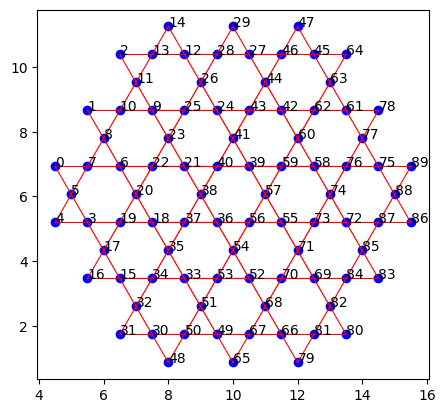

In [23]:
colors = plt.cm.jet(np.linspace(0,1,2))
fig, ax = plt.subplots()
plotting_utils.plot_lattice(kagome_restrcited, ax, annotate=True)
plotting_utils.plot_bonds(nodes_nn, ax, lw=results_gs['x'])
ax.set_aspect('equal')

#### Vison

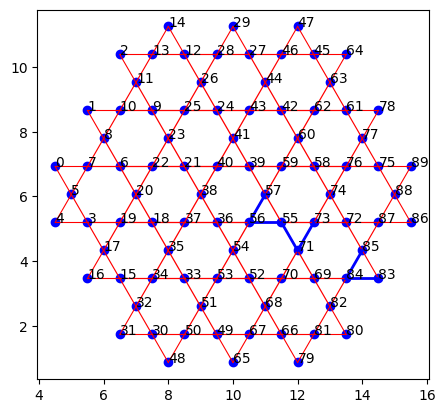

In [141]:
vison_branch = np.array([
  [57, 56, 56, 55, 55, 71, 71, 73, 85, 84, 84, 83]
])
nodes_vison_branch = node_collections.NodesCollection(vison_branch, kagome_restrcited)
colors = plt.cm.jet(np.linspace(0,1,2))
fig, ax = plt.subplots()
plotting_utils.plot_lattice(kagome_restrcited, ax, annotate=True)
plotting_utils.plot_bonds(nodes_nn, ax, lw=results_gs['x'])
plotting_utils.plot_loops(nodes_vison_branch, ax, c='b')
ax.set_aspect('equal')

In [146]:
# Get signs of the vison branch
vison_branch_edges = node_collections.extract_edge_sequence(nodes_vison_branch)
vison_branch_idx = nodes_nn_both_directions.idx_from_sites(vison_branch_edges)
Q_signs = np.ones(nodes_nn.count)
Q_signs[vison_branch_idx % len(Q_signs)] = -1

In [150]:
vison_branch_idx % len(Q_signs)

array([[110, 106, 108, 136, 156, 154]])

In [153]:
energy_Q = lambda Q_init: landau_energies.compute_energy_loop(
    couplings, Q_init, Q_signs, all_loops_nodes, nodes_nn_both_directions
)
linear_constraint = LinearConstraint(np.diag(Q_init), np.zeros_like(Q_init), 5 * np.ones_like(Q_init))
results_vison = minimize(
    energy_Q,
    Q_init,
    method='trust-constr',
     constraints=linear_constraint,
    options={'verbose': 1}
)

`xtol` termination condition is satisfied.
Number of iterations: 156, function evaluations: 36186, CG iterations: 3061, optimality: 6.27e-07, constraint violation: 0.00e+00, execution time: 5.9e+02 s.


In [154]:
print(results_vison['fun'])
print(results_vison['success'])
print(results_vison['message'])
print(results_vison['status'])
results_vison['x']

-49.88282186329043
True
`xtol` termination condition is satisfied.
2


array([0.78624529, 0.78624525, 0.79543955, 0.79543955, 0.78624536,
       0.7862454 , 0.78624531, 0.82621837, 0.8366685 , 0.86839661,
       0.78624535, 0.82621845, 0.86839661, 0.87200025, 0.89562816,
       0.8988224 , 0.83666851, 0.83795544, 0.87200031, 0.86839667,
       0.89882249, 0.89562818, 0.83666852, 0.82621839, 0.82621842,
       0.78624535, 0.86839665, 0.83666851, 0.7862454 , 0.79543953,
       0.8379555 , 0.83666849, 0.87200028, 0.79543957, 0.87200029,
       0.89882242, 0.90309286, 0.90107767, 0.9053072 , 0.89562817,
       0.90309294, 0.90530725, 0.90530727, 0.89296326, 0.89296329,
       0.90107772, 0.90309296, 0.90309299, 0.89882252, 0.90530731,
       0.90107781, 0.89562823, 0.8720003 , 0.83795558, 0.79543948,
       0.87200037, 0.83666858, 0.79543954, 0.78624534, 0.82621837,
       0.78624539, 0.82621842, 0.7862453 , 0.86839659, 0.89562813,
       0.90309289, 0.89562822, 0.90309298, 0.89882242, 0.9053072 ,
       0.89296322, 0.82971641, 0.89296325, 0.82971644, 0.89296

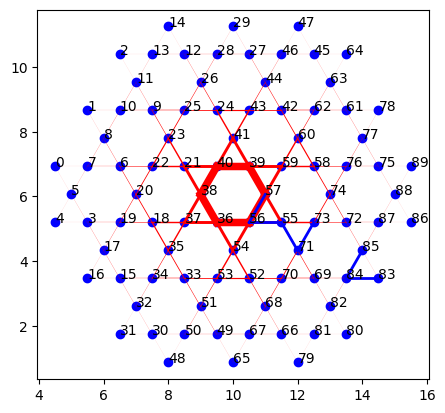

In [158]:
Q_difference = np.abs(results_gs['x'] - results_vison['x'])
colors = plt.cm.jet(np.linspace(0,1,2))
fig, ax = plt.subplots()
plotting_utils.plot_lattice(kagome_restrcited, ax, annotate=True)
plotting_utils.plot_bonds(nodes_nn, ax, lw=Q_difference * 50)
plotting_utils.plot_loops(nodes_vison_branch, ax, c='b')
ax.set_aspect('equal')

# Get visons

In [18]:
def get_visons(
    beta, 
    k,
    visonBonds_idx, 
    listEBs,
    bonds_dict,
    Q_flip,
    Q_init,
    Q0=1
):
  couplings = {'alpha':1, "beta":beta, "K":k}
  energy_Q = lambda Q_init: landau_energies.compute_energy_loop(couplings, Q_init, Q0, ListEBs, bonds_dict)
  linear_constraint = LinearConstraint(np.diag(Q_init), np.zeros_like(Q_init), 1 * np.ones_like(Q_init))
  results_gs = minimize(energy_Q, Q_init, tol=1e-3) 
  if results_gs['success']:
    Q_init_vs = copy.copy(results_gs['x'])
    for idx in visonBonds_idx:
      Q_init_vs[idx] = -1 * Q_init_vs[idx]
    
    energy_Q = lambda Q_init_vs: landau_energies.compute_energy_loop(couplings, Q_init_vs, Q0, listEBs, bonds_dict)
    linear_constraint = LinearConstraint(np.diag(Q_flip), np.zeros_like(Q_init_vs),  1 * np.ones_like(Q_init_vs))
    results_vison = minimize(energy_Q, Q_init_vs, method='trust-constr', 
                   constraints=linear_constraint,
                   options={'verbose': 1},
                   tol=1e-3
                   )
    return results_vison['success'], results_vison['fun'], results_vison['x']
  else:
    return False, 0., np.zeros_like(Q_init)